In [27]:
import swarms
from numpy import linspace, logspace, pi, array
import matplotlib.pyplot as plt

In [38]:
RHO=1500
M0 = 1e-2 * 7.34767309e22; d_pl = 20 * 3.086e16; star_type = "M"
eta = 0.4; Nstr = 6.; Dt = 100.; Dmax = 150000.; R_pl = 6.9911e7

lamb = 1.65e-6
time = [1e7, 3e7, 1e8, 3e8]
M_jup = [(1./10.)*1.89587112e27, (1./3.)*1.89587112e27, (1.)*1.89587112e27, (4./3.)*1.89587112e27]
a_plv = linspace(2 * 1.496e11, 80 * 1.496e11, 500)

In [39]:
def Fstar(Ls, Bnu, Ts, dpl):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = Ls * Bnu
    part2 = 4 * sig * Ts ** 4 * dpl ** 2
    return part1 / part2

In [40]:
def find_star_flux(type_star, lamb):
    if type_star == "A":
        M_s = 2.1 * 1.989e30
        L_s = 20 * 3.828e26
    elif type_star == "G":
        M_s = 1 * 1.989e30
        L_s = 1 * 3.828e26
    elif type_star == "M":
        M_s = 0.21 * 1.989e30
        L_s = 0.0079 * 3.828e26

    return M_s, L_s

C:\Users\loloynage\Documents\CE-Irregular-Satellites\src\swarms.py:270: RuntimeWarning: overflow encountered in exp
  b = 1/(exp(h*(c/lamb)/(k_B*T)) - 1)


<Figure size 432x288 with 0 Axes>

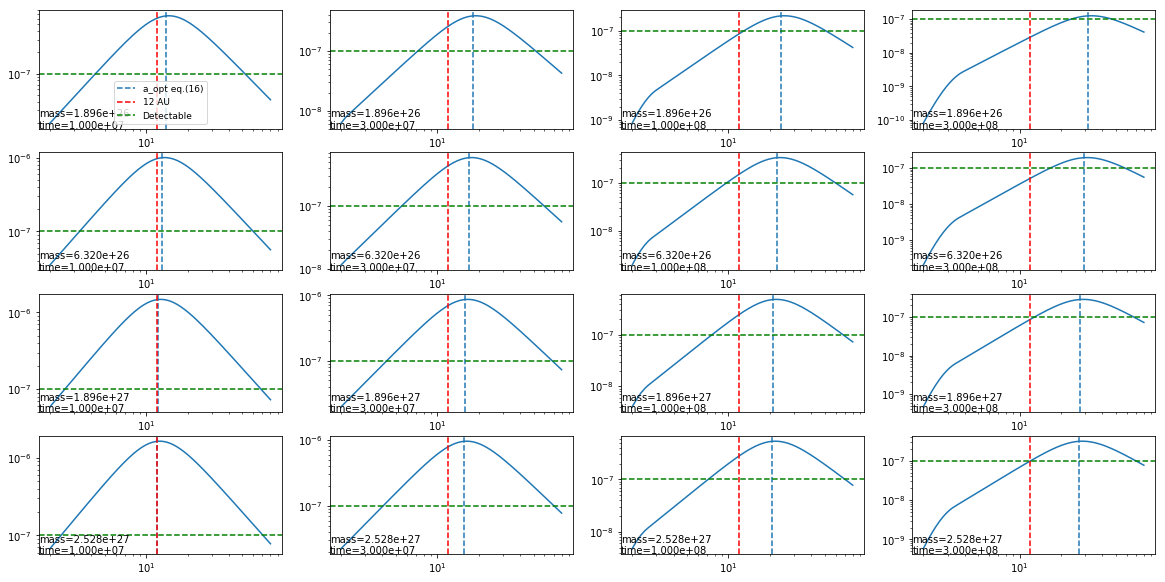

In [41]:
plt.figure(1)
fig, axes = plt.subplots(len(M_jup), len(time), subplot_kw=dict(), figsize=(20, 10))
M_s, L_s = find_star_flux(star_type, lamb)
for w in range(len(M_jup)):
    for k in range(len(time)):    
        
        fth_list = []
        fs_list = []
        for i in range(len(a_plv)):

            s = swarms.CollSwarm(M0, Dt, Dmax, L_s, M_s, M_jup[w], a_plv[i], R_pl, eta, Nstr,
                        d_pl, correction=True, alpha=1.2)

            s.updateSwarm(time[k])
            T_star = s.stellarTemp()
            B_nu_list = s.computeBmu(array([lamb]), T_star)
            F_star = Fstar(L_s, B_nu_list, T_star, d_pl)/1e-26

            f_vrel = 4/pi
            Qd = s.computeQd(s.Dc)
            part1 = (M_s/1.989e30)**0.33 * f_vrel**0.55
            part2 = (M_jup[w]/5.972e24)**0.06 * Qd**0.15 * eta
            part3 = time[k] * (M0/5.972e24) / (RHO * (s.Dc/1000)) 

            a_opt = 50 * part1 / part2 * part3**0.24 
            
            
            s2 = swarms.CollSwarm(M0, Dt, Dmax, L_s, M_s, M_jup[w],
                                    a_plv[i], R_pl, eta, Nstr, d_pl,
                                    rho=RHO, fQ=5, f_vrel=4/pi,
                                    correction=True, alpha=1.2)

            s2.updateSwarm(time[k])

            F_th = s2.computeFth(array([lamb]), swarm=True)
            F_s = s2.computeFs(array([lamb]), 0.32, 0.08, swarm=True)

            fth_list.append(F_th[0]/1e-26)
            fs_list.append(F_s[0]/1e-26)

        contrast_ratio_apl_th = array(fth_list) / F_star
        contrast_ratio_apl_s = array(fs_list) / F_star

        axes[w, k].loglog(a_plv/1.496e11, contrast_ratio_apl_s)
        axes[w, k].axvline(a_opt, ls='--',label="a_opt eq.(16)")
        axes[w, k].axvline(12, color='r', ls='--',label="12 AU")
        axes[w, k].axhline(1e-7, color='g', ls='--',label="Detectable")
        axes[w, k].text(0, 0, 'mass={0:.3e}'.format(M_jup[w])+'\n'+'time={0:.3e}'.format(time[k]), transform=axes[w, k].transAxes) 
        if w == 0 and k == 0:
            axes[w, k].legend(prop={'size': 9})
            #axes[w, k].xlabel("a_pl [au]")
            #axes[w, k].ylabel("F_swarm / F_star")
plt.show()